# About

Detect if a person is smiling or not.  From Coursera Deep Learning Specialization - Course 4 - Convolutional Neural Networks.

# Setup

### Download Dataset (run once)

In [1]:
!kaggle datasets download -d iarunava/happy-house-dataset -p ../data/happy-house
!unzip ../data/happy-house/happy-house-dataset.zip -d ../data/happy-house/
!chmod 644 ../data/happy-house/*.h5

happy-house-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


### Load Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load fastai libraries
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# load additional libraries
import h5py

In [4]:
# verify GPU
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


# Inspect data

In [5]:
def load_dataset(path_to_train, path_to_test):
    train_dataset = h5py.File(path_to_train)
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test)
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # y reshaped
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y

In [6]:
PATH = "../data/happy-house"
X_train, Y_train, X_test, Y_test = load_dataset(f"{PATH}/train_happy.h5", f"{PATH}/test_happy.h5")
# swap dimensions (Andrew Ng likes them flipped around)
Y_train = Y_train.T.squeeze()
Y_test = Y_test.T.squeeze()

In [7]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(600, 64, 64, 3) (600,)
(150, 64, 64, 3) (150,)


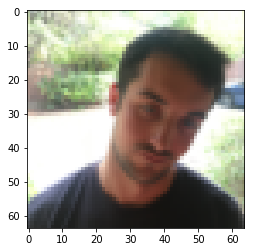

In [8]:
plt.imshow(X_train[0])

In [9]:
Y_train[0]

0

# Model

In [10]:
# setup architecture
arch = resnet34
sz = 64
bs = 30

In [11]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_arrays(path='tmp', 
                                       trn=(X_train, Y_train),
                                       val=(X_test, Y_test),
                                       bs=bs,
                                       classes=Y_train,
                                       tfms=tfms)

In [12]:
data = get_data(sz)

In [13]:
# run learner with precompute enabled
learn = ConvLearner.pretrained(arch, data, precompute=True)

  5%|▌         | 1/20 [00:00<00:13,  1.38it/s, loss=1.26]


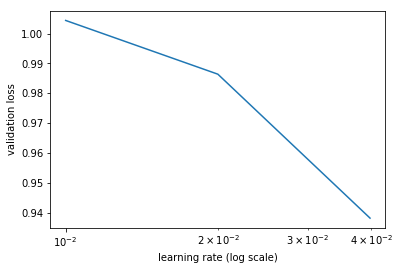

In [14]:
# find optimal learning rate
lrf = learn.lr_find()
learn.sched.plot()

In [15]:
lr = 0.01

In [16]:
learn.fit(lr, 5, cycle_len=2, cycle_mult=3)

epoch      trn_loss   val_loss   accuracy                
    0      0.665667   0.810648   0.68      
    1      0.504035   0.346914   0.853333                 
    2      0.427385   0.329645   0.853333                 
    3      0.378809   0.251953   0.913333                 
    4      0.346383   0.271361   0.886667                 
    5      0.309302   0.220287   0.92                    
    6      0.300806   0.211828   0.933333                 
    7      0.273834   0.204304   0.933333                 
    8      0.266342   0.189781   0.92                     
    9      0.253591   0.208089   0.926667                
    10     0.256185   0.240562   0.9                      
    11     0.257116   0.288181   0.86                     
    12     0.262645   0.215969   0.906667                 
    13     0.237415   0.199104   0.933333                 
    14     0.229506   0.211803   0.926667                
    15     0.222804   0.171859   0.946667                 
    16     0.215

[array([0.0995]), 0.9599999904632568]

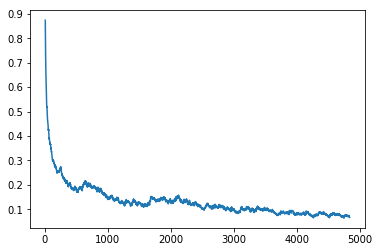

In [17]:
learn.sched.plot_loss()

In [18]:
# add test time augmentation
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [19]:
accuracy_np(probs, y)

0.96

### Confusion Matrix

In [20]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[65  1]
 [ 5 79]]


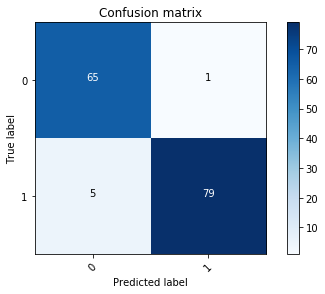

In [22]:
classes = np.unique(Y_train)
plot_confusion_matrix(cm, classes)

### Incorrect predictions

In [23]:
def load_img_id(idx):
    #print(idx)
    img = X_test[idx].reshape(64,64,3)
    return img

def plot_val_with_title(idxs, title):
    print(idxs)
    imgs = [load_img_id(x) for x in idxs]
    title_probs = [(preds[x], y[x]) for x in idxs]
    print(title)
    return plots(imgs, rows=4, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

In [24]:
# count incorrect predictions
incorrect_digits = np.where(preds != y)[0]
len(incorrect_digits)

6

[ 53  63  65  95 120 145]
Incorrect digits (prediction, label)


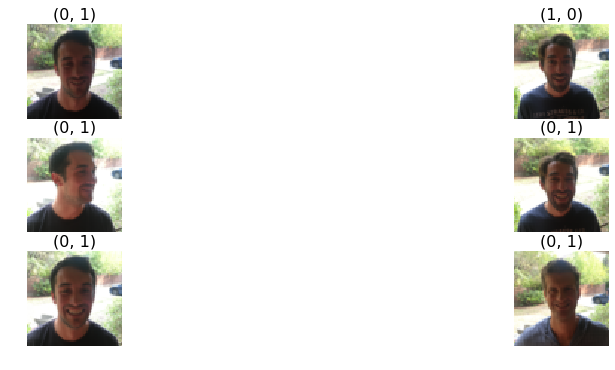

In [25]:
# visualize incorrect predictions
plot_val_with_title(incorrect_digits, "Incorrect digits (prediction, label)")